# 案例-评分卡制作

该数据是信贷数据,来自kaggle2011年的竞赛数据:[Give Me Some Credit](https://www.kaggle.com/c/GiveMeSomeCredit/overview),评判指标是AUC

- SeriousDlqin2yrs:出现90天或更长时间的逾期行为(即定义好坏客户)
- RevolvingUtilizationOfUnsecuredLines:贷款以及信用卡可用额度与总额度比例
- age:借款人借款年龄
- NumberOfTime30-59DaysPastDueNotWorse:过去两年内出现35-59天逾期但是没有发展的更坏的次数
- DebtRatio:每月偿还债务,赡养费,生活费用除以月总收入
- MonthlyIncome:月收入
- NumberOfOpenCreditLinesAndLoans:开放式贷款和信贷数量
- NumberOfTimes90DaysLate:借款者有90天或更高逾期的次数
- NumberRealEstateLoansOrLines:抵押贷款和房地产贷款数量,包括房屋净值信贷额度
- NumberOfTime60-89DaysPastDueNotWorse:过去两年内出现60-89天逾期但是没有发展的更坏的次数
- NumberOfDependents:家庭中不包括自身的家属人数(配偶,子女等)

数据描述
数据探索：单变量分析、多变量的分析（X和X,X和Y)
数据清洗：重复值、缺失值、异常值
特征工程：特征构建（生成、组合、降维、变换）、特征筛选、特征编码
模型构建：合适的模型
模型评估：交叉验证【稳定性】
模型调优：学习曲线、网格搜索、组合模型（bagging、stacking）、提升算法（boosting）、深度学习框架【提升泛化能力】

## 读数据,数据描述

In [31]:
train_data = pd.read_csv("./data/cs-training.csv",index_col=0)
# index_col指明y的索引是第几列

In [32]:
print(train_data.shape)
train_data.describe(include="all",percentiles=[0.5]).T.round(2)

(150000, 11)


count     mean       std  min  \
SeriousDlqin2yrs                      150000.0     0.07      0.25  0.0   
RevolvingUtilizationOfUnsecuredLines  150000.0     6.05    249.76  0.0   
age                                   150000.0    52.30     14.77  0.0   
NumberOfTime30-59DaysPastDueNotWorse  150000.0     0.42      4.19  0.0   
DebtRatio                             150000.0   353.01   2037.82  0.0   
MonthlyIncome                         120269.0  6670.22  14384.67  0.0   
NumberOfOpenCreditLinesAndLoans       150000.0     8.45      5.15  0.0   
NumberOfTimes90DaysLate               150000.0     0.27      4.17  0.0   
NumberRealEstateLoansOrLines          150000.0     1.02      1.13  0.0   
NumberOfTime60-89DaysPastDueNotWorse  150000.0     0.24      4.16  0.0   
NumberOfDependents                    146076.0     0.76      1.12  0.0   

                                          50%        max  
SeriousDlqin2yrs                         0.00        1.0  
RevolvingUtilizationOfUnsecuredLines     0.15    50708.0  
age                                     52.00      109.0  
NumberOfTime30-59DaysPastDueNotWorse     0.00       98.0  
DebtRatio                                0.37   329664.0  
MonthlyIncome                         5400.00  3008750.0  
NumberOfOpenCreditLinesAndLoans          8.00       58.0  
NumberOfTimes90DaysLate                  0.00       98.0  
NumberRealEstateLoansOrLines             1.00       54.0  
NumberOfTime60-89DaysPastDueNotWorse     0.00       98.0  
NumberOfDependents                       0.00       20.0

修改列名:由于一些算法中,列名中的某些符号会带来问题甚至报错,例如这里的"-",会在回归公式中被认为是减号,所以换成"_"

In [63]:
train_data.columns = train_data.columns.map(lambda x: x.replace("-","_"))

查看各列缺失值占比

In [7]:
train_data.isnull().mean()

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30_59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.198207
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60_89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.026160
dtype: float64

### 去重

- 对于一般模型影响不大,容易导致回归系数标准误降低,使得对应p值减小

In [33]:
train_data.drop_duplicates(inplace=True)
train_data.shape

(149391, 11)

- 可见数据中存在重复行

## 缺失值处理

缺失值处理方法的选择,主要依据是业务逻辑和缺失值占比,在对预测结果的影响尽可能小的情况下,对缺失值进行处理以满足算法需求,所以要理解每个缺失值处理方法带来的影响,下面的缺失值处理方法没有特殊说明均是对特征(列)的处理:

1. 占比较多:如80%以上:删除缺失值所在的列
    - 如果某些行缺失值占比较多,或者缺失值所在字段是苛刻的必须有值的,删除行
2. 占比一般:如30%-80%:将缺失值作为单独的一个分类
    - 如果特征是连续的,则其他已有值分箱
    - 如果特征是分类的,考虑其他分类是否需要重分箱
3. 占比少:10%-30%:多重插补:认为若干特征之间有相关性,则可以相互预测缺失值
    - 需满足的假设:MAR:Missing At Random:数据缺失的概率仅和已观测的数据相关,即缺失的概率与未知的数据无关,即与变量的具体数值无关
    - 迭代(循环)次数可能的话超过40,选择所有的变量甚至额外的辅助变量
    - 详细的计算过程参考:[Multiple Imputation by Chained Equations: What is it and how does it work?](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/)
4. 占比较少:10%以下:单一值替换,如中位数,众数
5. 在决策树中可以将缺失值处理融合到算法里:按比重分配

这里的占比并不是固定的,例如缺失值占比只有5%,仍可以用第二种方法,主要依据业务逻辑和算法需求

### 查看缺失值分布情况

In [34]:
import missingno as msno
# 处理缺失值的包,需要安装

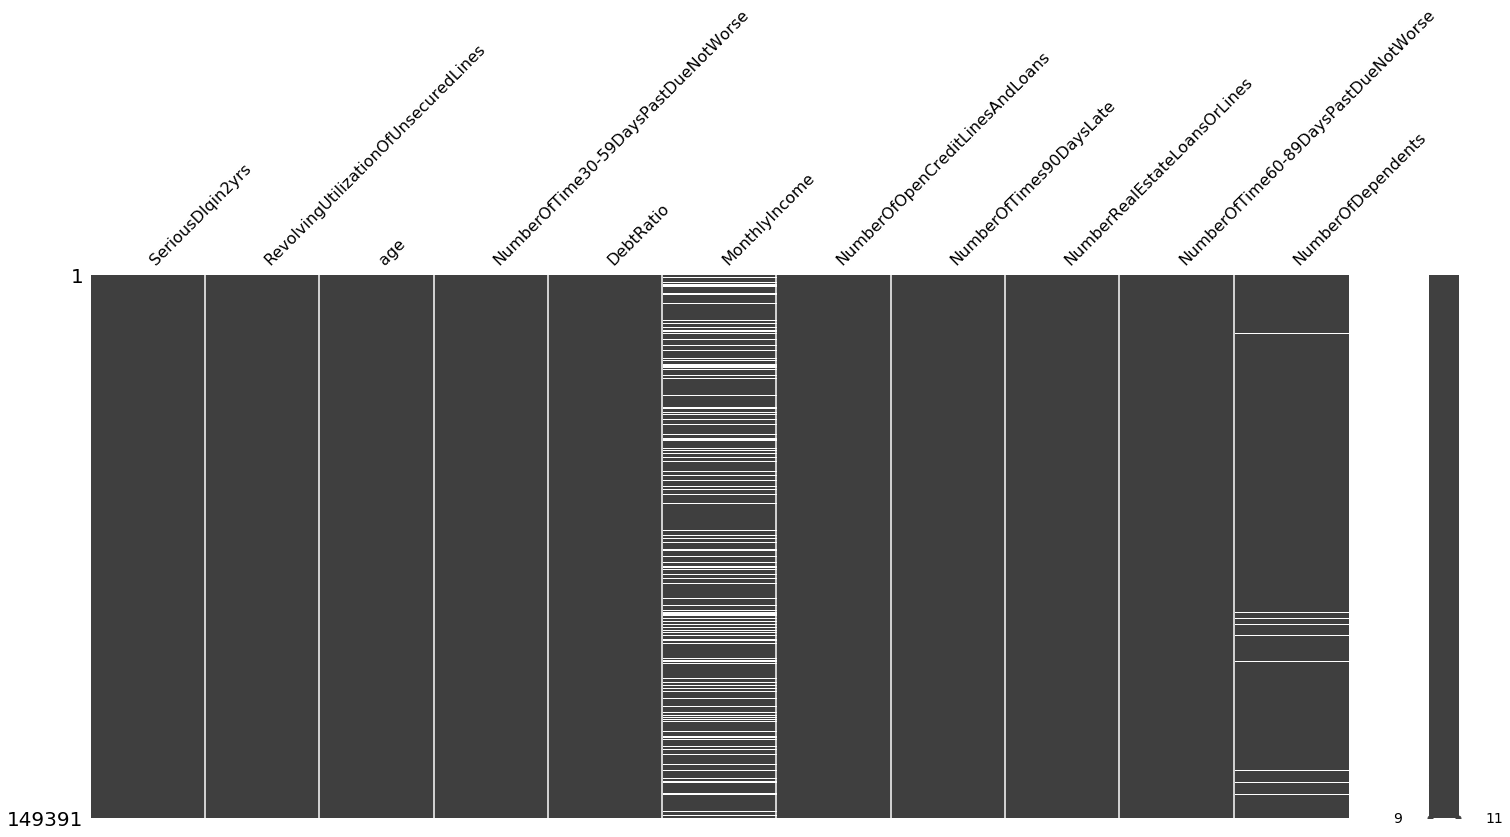

In [35]:
msno.matrix(train_data)
plt.show()

imshow：热图（heatmap）是数据分析的常用方法，通过色差、亮度来展示数据的差异、易于理解。Python在Matplotlib库中，调用imshow()函数实现热图绘制。

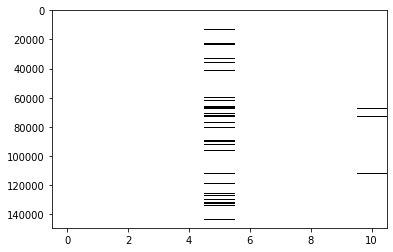

In [36]:
plt.imshow(~train_data.isna(),aspect="auto") # auto: 更改图像宽高比以匹配轴的宽高比。
plt.gray()

本数据的缺失值处理逻辑:

- 对于信用评分卡来说,由于所有变量都需要分箱,故这里缺失值作为单独的箱子即可
- 对于最后一列NumberOfDependents,缺失值占比只有2.56%,作为单独的箱子信息不够,故做单一值填补,这列表示家庭人口数,有右偏的倾向,且属于计数的数据,故使用中位数填补
- 这里没必要进行多重插补,下面的多重插补只是为了让读者熟悉此操作

### 尝试多重插补

In [37]:
from statsmodels.imputation import mice  # 基于链式的多重插补
# 加载所需包

In [38]:
imdata = train_data.copy()
# 拷贝数据
imp = mice.MICEData(imdata)
# 指定数据
imp.update_all(20)
# 指定MICE的迭代次数

PatsyError: Error evaluating factor: NameError: name 'NumberOfTime30' is not defined
    NumberOfDependents ~ SeriousDlqin2yrs + RevolvingUtilizationOfUnsecuredLines + age + NumberOfTime30-59DaysPastDueNotWorse + DebtRatio + MonthlyIncome + NumberOfOpenCreditLinesAndLoans + NumberOfTimes90DaysLate + NumberRealEstateLoansOrLines + NumberOfTime60-89DaysPastDueNotWorse
                                                                                         ^^^^^^^^^^^^^^

可以看到所有的缺失值已经填补了

随机森林填补法

In [39]:
from sklearn.ensemble import RandomForestRegressor  # 随机森林回归器

In [40]:
train_data.head()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
1                 1                              0.766127   45   
2                 0                              0.957151   40   
3                 0                              0.658180   38   
4                 0                              0.233810   30   
5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
1                                     2   0.802982         9120.0   
2                                     0   0.121876         2600.0   
3                                     1   0.085113         3042.0   
4                                     0   0.036050         3300.0   
5                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
1                               13                        0   
2                                4                        0   
3                                2                        1   
4                                5                        0   
5                                7                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
1                             6                                     0   
2                             0                                     0   
3                             0                                     0   
4                             0                                     0   
5                             1                                     0   

   NumberOfDependents  
1                 2.0  
2                 1.0  
3                 0.0  
4                 0.0  
5                 0.0

In [41]:
def fill_missing(data,to_fill):
    '''
    data:传递的数据集
    to_fill:需要填补的列名'''
    df = data.copy()  # 复制原表，防止操作错误
    columns = [*train_data.columns]  #特征
    columns.remove(to_fill)
    columns.remove('NumberOfDependents')
    columns.remove('SeriousDlqin2yrs')
    # 提取特征和预测标签
    X = df.loc[:,columns]
    Y = df.loc[:,to_fill]
    # 划分数据集：训练集是没有缺失值的样本，测试集是缺失的样本
    Xtrain = X.loc[df[to_fill].notnull()]
    Xpred = X.loc[df[to_fill].isnull()]
    Ytrain = Y.loc[df[to_fill].notnull()]
    # 建模
    model = RandomForestRegressor(random_state=0,
                                  n_estimators=100,
                                  max_depth=3,
                                 n_jobs=-1)
    model.fit(Xtrain,Ytrain)
    pred = model.predict(Xpred).round()
    df.loc[df[to_fill].isnull(),to_fill]=pred
    return df

In [42]:
train_data = fill_missing(train_data,'MonthlyIncome')

In [43]:
train_data.isnull().mean()

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.000000
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.025624
dtype: float64

In [44]:
train_data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

### 单一值替换

将最后一列NumberOfDependents的缺失值替换成中位数 

In [45]:
train_data['NumberOfDependents'].value_counts()

0.0     86392
1.0     26314
2.0     19521
3.0      9483
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
9.0         5
10.0        5
13.0        1
20.0        1
Name: NumberOfDependents, dtype: int64

In [46]:
NOD_median =  train_data["NumberOfDependents"].median()
train_data["NumberOfDependents"].fillna(NOD_median,inplace=True)
# fillna填补缺失值的函数,这里用中位数填补

## 异常值处理

异常值常见的处理方法:

1. 删除所在的行
2. 替换成缺失值,与缺失值一起处理
3. 盖帽法处理

结合业务逻辑和算法需求判断是否需要处理异常值以及如何处理,一般情况下盖帽法即可,即将极端异常的值改成不那么异常的极值,当然一些算法例如决策树中连续变量的异常值也可以不做处理

### 定义盖帽法函数

In [47]:
def block(x,lower=True,upper=True):
# x是输入的Series对象,lower表示是否替换1%分位数,upper表示是否替换99%分位数
    ql = x.quantile(.01)
    qu = x.quantile(.99)
    if lower:
        out = x.mask(x<ql,ql)
    if upper:
        out = x.mask(x>qu,qu)
    return(out)

- 互换y中的0,1

In [48]:
train_data.SeriousDlqin2yrs.value_counts()

0    139382
1     10009
Name: SeriousDlqin2yrs, dtype: int64

In [49]:
train_data["SeriousDlqin2yrs"] = 1-train_data.SeriousDlqin2yrs

In [50]:
train_data.SeriousDlqin2yrs.value_counts()

1    139382
0     10009
Name: SeriousDlqin2yrs, dtype: int64

### 汇总清洗过程,生成函数

In [51]:
def datacleaning(testdata,include_y=False):   # 参数：测试数据、默认没有y标签
    testdata.columns = testdata.columns.map(lambda x: x.replace("-","_"))
    testdata["NumberOfDependents"].fillna(NOD_median,inplace=True)
    if include_y:
        testdata["SeriousDlqin2yrs"] = -(testdata["SeriousDlqin2yrs"]-1)
    return(testdata)

## 对每个x生成分箱对象

对每个x生成一个对象;记录IV值;生成WOE图

- 运行自定义函数所在的文件

In [52]:
%run smob.py

<Figure size 432x288 with 0 Axes>

- 定义y的名字
- 初始化IV值对象

In [53]:
y = "SeriousDlqin2yrs"
iv_all = pd.Series()

/Users/mac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


### RevolvingUtilizationOfUnsecuredLines

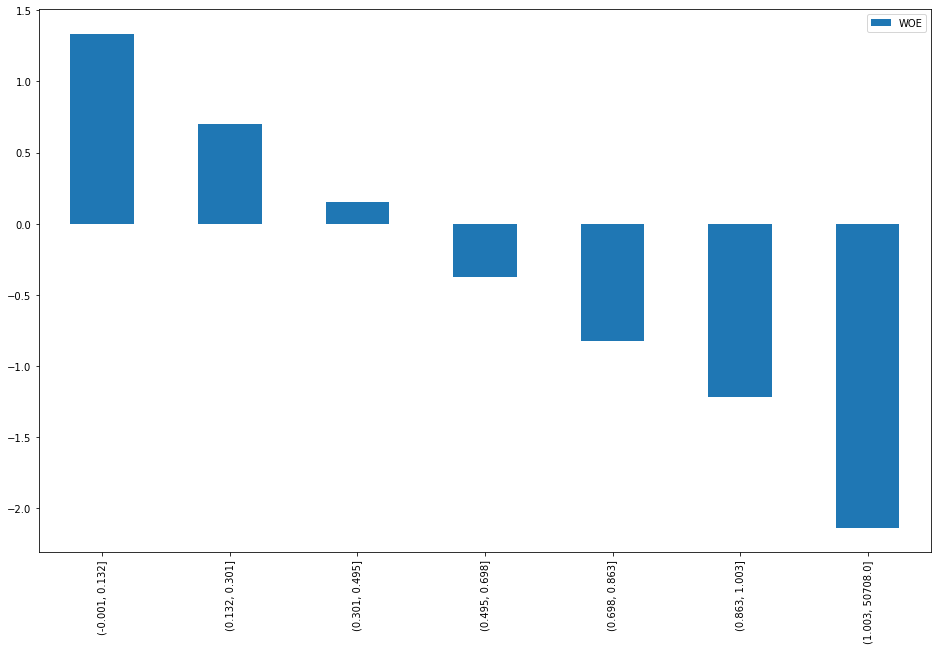

In [54]:
RUO = smbin(train_data,y,"RevolvingUtilizationOfUnsecuredLines")

- 查看IVtable

In [55]:
RUO.IVtable

Bins  CntRec  CntGood  CntBad    PctRec   PctGood    PctBad  \
0   (-0.001, 0.132]   70734    69424    1310  0.473482  0.498084  0.130882   
1    (0.132, 0.301]   21938    21185     753  0.146850  0.151992  0.075232   
2    (0.301, 0.495]   15380    14486     894  0.102951  0.103930  0.089320   
3    (0.495, 0.698]   11599    10499    1100  0.077642  0.075325  0.109901   
4    (0.698, 0.863]    7985     6860    1125  0.053450  0.049217  0.112399   
5    (0.863, 1.003]   18592    14962    3630  0.124452  0.107345  0.362674   
6  (1.003, 50708.0]    3163     1966    1197  0.021173  0.014105  0.119592   
7             Total  149391   139382   10009  1.000000  1.000000  1.000000   

      WOE      IV  
0  1.3365  0.4908  
1  0.7032  0.0540  
2  0.1515  0.0022  
3 -0.3778  0.0131  
4 -0.8258  0.0522  
5 -1.2175  0.3109  
6 -2.1376  0.2255  
7     NaN  1.1487

- 查看树结构

In [56]:
print(RUO.Tree_structure)

The cart tree structure has 13 nodes, tree structure: 
node = 0 test node: go to node 1 if RevolvingUtilizationOfUnsecuredLines <= 0.7 else to node 2.
	node = 1 test node: go to node 5 if RevolvingUtilizationOfUnsecuredLines <= 0.3 else to node 6.
	node = 2 test node: go to node 3 if RevolvingUtilizationOfUnsecuredLines <= 1.0 else to node 4.
		node = 3 test node: go to node 7 if RevolvingUtilizationOfUnsecuredLines <= 0.86 else to node 8.
		node = 4 leaf node.
		node = 5 test node: go to node 11 if RevolvingUtilizationOfUnsecuredLines <= 0.13 else to node 12.
		node = 6 test node: go to node 9 if RevolvingUtilizationOfUnsecuredLines <= 0.49 else to node 10.
			node = 7 leaf node.
			node = 8 leaf node.
			node = 9 leaf node.
			node = 10 leaf node.
			node = 11 leaf node.
			node = 12 leaf node.



- 保存IV值

In [57]:
iv_all = iv_all.append(pd.Series({"RevolvingUtilizationOfUnsecuredLines":RUO.IV}))

In [58]:
iv_all

RevolvingUtilizationOfUnsecuredLines    1.1487
dtype: float64

### age

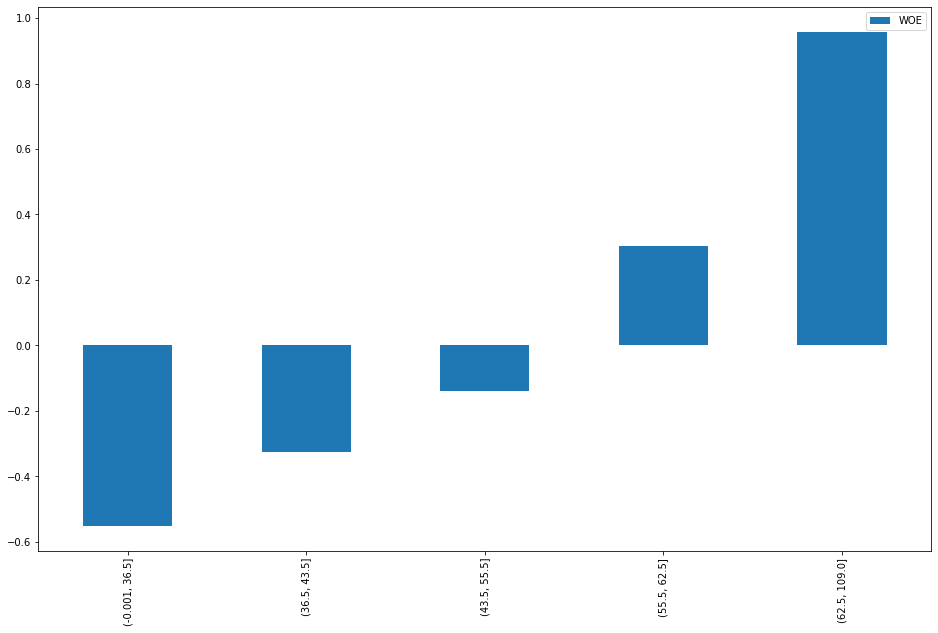

In [59]:
age = smbin(train_data,y,"age")

- 查看IVtable

In [60]:
age.IVtable

Bins  CntRec  CntGood  CntBad    PctRec   PctGood    PctBad  \
0  (-0.001, 36.5]   23628    21011    2617  0.158162  0.150744  0.261465   
1    (36.5, 43.5]   20609    18746    1863  0.137953  0.134494  0.186132   
2    (43.5, 55.5]   43428    40119    3309  0.290700  0.287835  0.330602   
3    (55.5, 62.5]   23972    22764    1208  0.160465  0.163321  0.120691   
4   (62.5, 109.0]   37754    36742    1012  0.252719  0.263606  0.101109   
5           Total  149391   139382   10009  1.000000  1.000000  1.000000   

      WOE      IV  
0 -0.5507  0.0610  
1 -0.3249  0.0168  
2 -0.1385  0.0059  
3  0.3025  0.0129  
4  0.9583  0.1557  
5     NaN  0.2523

- 保存IV值

In [61]:
iv_all = iv_all.append(pd.Series({"age":age.IV}))

### NumberOfTime30_59DaysPastDueNotWorse

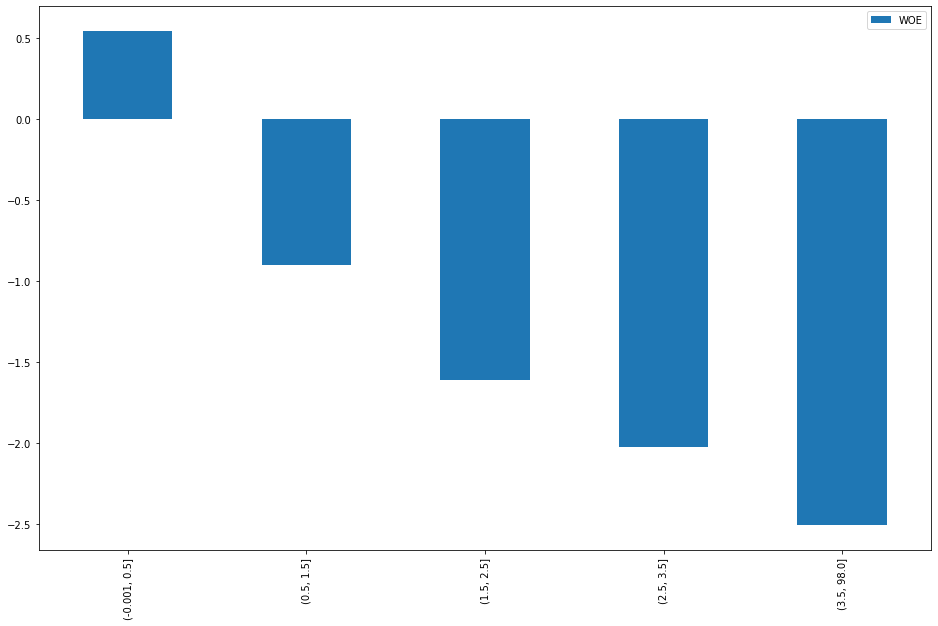

In [64]:
NO3059 = smbin(train_data,y,"NumberOfTime30_59DaysPastDueNotWorse")

In [65]:
NO3059.IVtable

Bins  CntRec  CntGood  CntBad    PctRec   PctGood    PctBad  \
0  (-0.001, 0.5]  125453   120418    5035  0.839763  0.863942  0.503047   
1     (0.5, 1.5]   16033    13624    2409  0.107322  0.097746  0.240683   
2     (1.5, 2.5]    4598     3379    1219  0.030778  0.024243  0.121790   
3     (2.5, 3.5]    1754     1136     618  0.011741  0.008150  0.061744   
4    (3.5, 98.0]    1553      825     728  0.010396  0.005919  0.072735   
5          Total  149391   139382   10009  1.000000  1.000000  1.000000   

      WOE      IV  
0  0.5408  0.1952  
1 -0.9011  0.1288  
2 -1.6142  0.1575  
3 -2.0250  0.1085  
4 -2.5087  0.1676  
5     NaN  0.7576

In [66]:
iv_all = iv_all.append(pd.Series({"NumberOfTime30_59DaysPastDueNotWorse":NO3059.IV}))

### DebtRatio

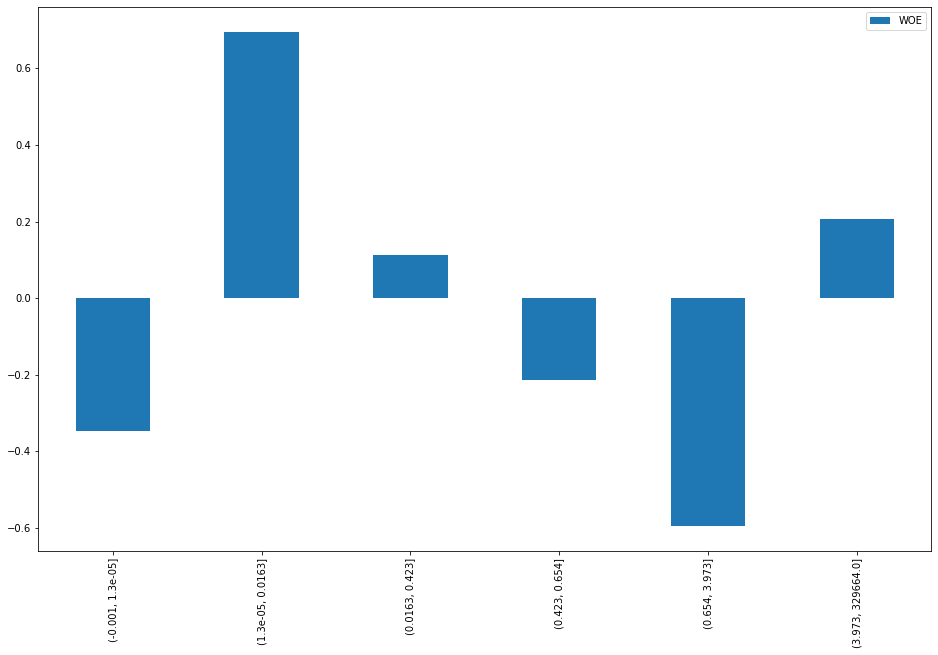

In [67]:
DebtRatio = smbin(train_data,y,"DebtRatio",10)

In [68]:
DebtRatio.IVtable

Bins  CntRec  CntGood  CntBad    PctRec   PctGood    PctBad  \
0  (-0.001, 1.3e-05]    3515     3191     324  0.023529  0.022894  0.032371   
1  (1.3e-05, 0.0163]    8296     8009     287  0.055532  0.057461  0.028674   
2    (0.0163, 0.423]   71689    67363    4326  0.479875  0.483298  0.432211   
3     (0.423, 0.654]   21179    19451    1728  0.141769  0.139552  0.172645   
4     (0.654, 3.973]   14648    12961    1687  0.098051  0.092989  0.168548   
5  (3.973, 329664.0]   30064    28407    1657  0.201244  0.203807  0.165551   
6              Total  149391   139382   10009  1.000000  1.000000  1.000000   

      WOE      IV  
0 -0.3464  0.0033  
1  0.6951  0.0200  
2  0.1117  0.0057  
3 -0.2128  0.0070  
4 -0.5947  0.0449  
5  0.2079  0.0080  
6     NaN  0.0889

In [69]:
iv_all = iv_all.append(pd.Series({"DebtRatio":DebtRatio.IV}))

### MonthlyIncome

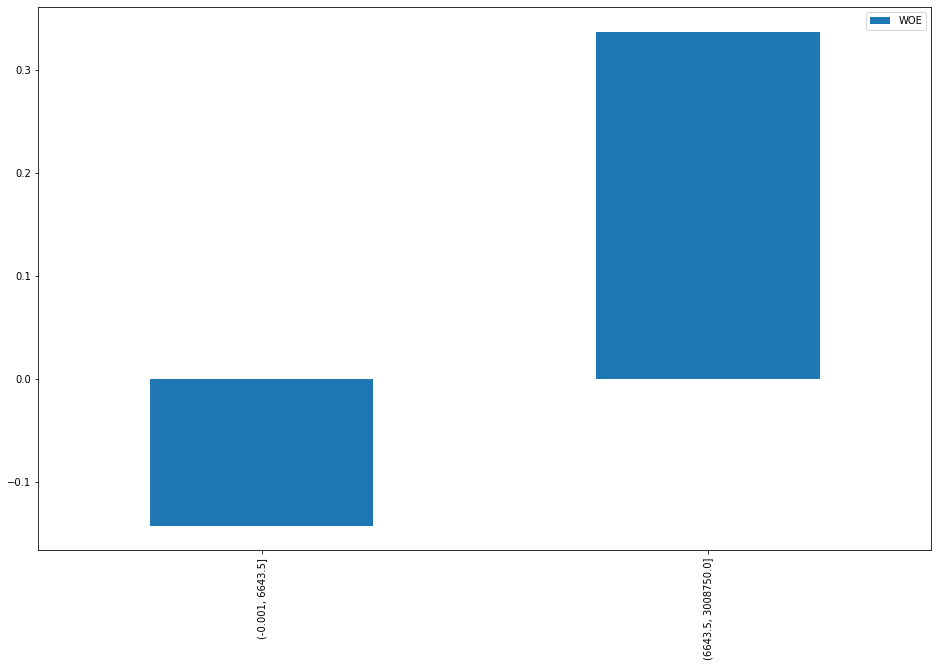

In [70]:
MonthlyIncome = smbin(train_data,y,"MonthlyIncome")

In [71]:
MonthlyIncome.IVtable

Bins  CntRec  CntGood  CntBad    PctRec   PctGood    PctBad  \
0     (-0.001, 6643.5]   98216    90702    7514  0.657443  0.650744  0.750724   
1  (6643.5, 3008750.0]   51175    48680    2495  0.342557  0.349256  0.249276   
2                Total  149391   139382   10009  1.000000  1.000000  1.000000   

      WOE      IV  
0 -0.1429  0.0143  
1  0.3372  0.0337  
2     NaN  0.0480

In [72]:
iv_all = iv_all.append(pd.Series({"MonthlyIncome":MonthlyIncome.IV}))

### NumberOfOpenCreditLinesAndLoans

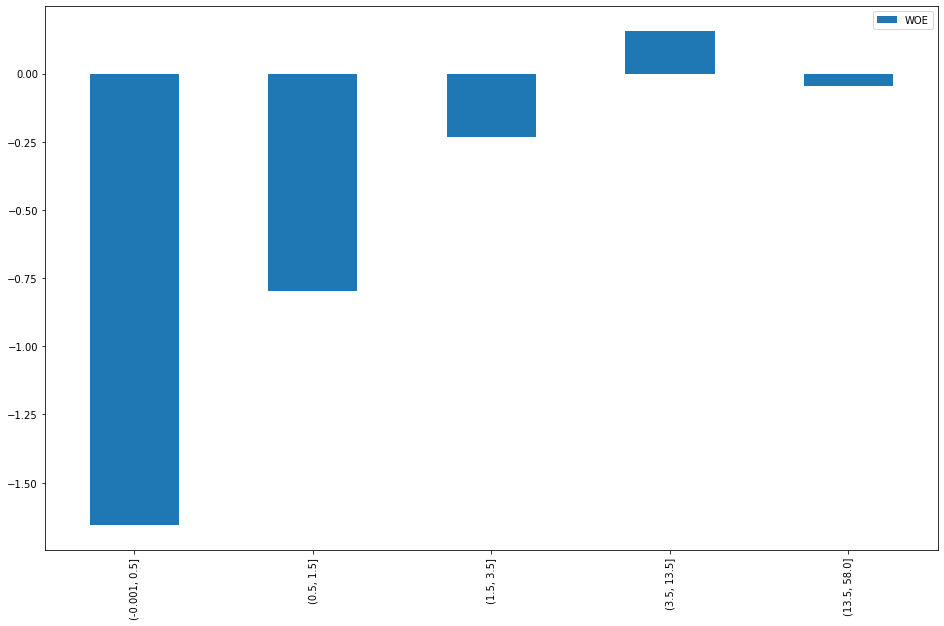

In [73]:
NOO = smbin(train_data,y,"NumberOfOpenCreditLinesAndLoans")

In [74]:
NOO.IVtable

Bins  CntRec  CntGood  CntBad    PctRec   PctGood    PctBad  \
0  (-0.001, 0.5]    1712     1244     468  0.011460  0.008925  0.046758   
1     (0.5, 1.5]    4251     3667     584  0.028456  0.026309  0.058347   
2     (1.5, 3.5]   15550    14259    1291  0.104089  0.102302  0.128984   
3    (3.5, 13.5]  105861    99732    6129  0.708617  0.715530  0.612349   
4   (13.5, 58.0]   22017    20480    1537  0.147378  0.146934  0.153562   
5          Total  149391   139382   10009  1.000000  1.000000  1.000000   

      WOE      IV  
0 -1.6561  0.0627  
1 -0.7965  0.0255  
2 -0.2318  0.0062  
3  0.1557  0.0161  
4 -0.0441  0.0003  
5     NaN  0.1108

In [75]:
iv_all = iv_all.append(pd.Series({"NumberOfOpenCreditLinesAndLoans":NOO.IV}))

### NumberOfTimes90DaysLate

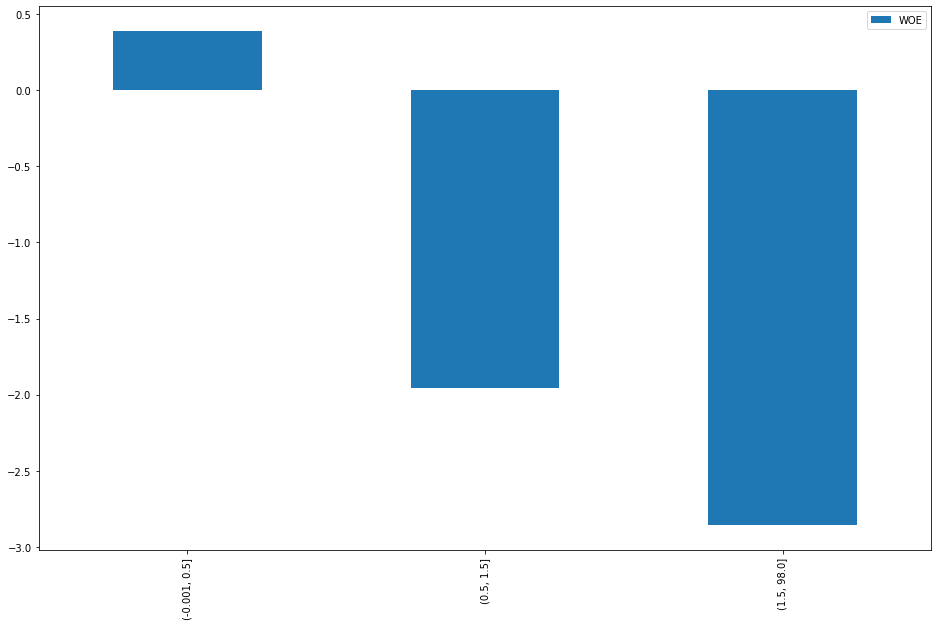

In [76]:
NO90 = smbin(train_data,y,"NumberOfTimes90DaysLate")

In [77]:
NO90.IVtable

Bins  CntRec  CntGood  CntBad    PctRec   PctGood    PctBad  \
0  (-0.001, 0.5]  141108   134559    6549  0.944555  0.965397  0.654311   
1     (0.5, 1.5]    5232     3468    1764  0.035022  0.024881  0.176241   
2    (1.5, 98.0]    3051     1355    1696  0.020423  0.009721  0.169447   
3          Total  149391   139382   10009  1.000000  1.000000  1.000000   

      WOE      IV  
0  0.3890  0.1210  
1 -1.9577  0.2963  
2 -2.8582  0.4565  
3     NaN  0.8738

In [78]:
iv_all = iv_all.append(pd.Series({"NumberOfTimes90DaysLate":NO90.IV}))

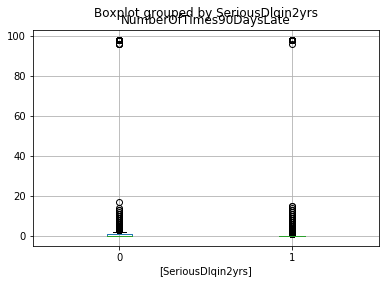

In [79]:
train_data.boxplot(column=["NumberOfTimes90DaysLate"],by=[y])

In [80]:
import scipy.stats as stats
stats.ttest_ind(train_data.loc[train_data.SeriousDlqin2yrs==1,"NumberOfTimes90DaysLate"],
                train_data.loc[train_data.SeriousDlqin2yrs==0,"NumberOfTimes90DaysLate"])

Ttest_indResult(statistic=-47.704547090568376, pvalue=0.0)

In [81]:
t0 = block(train_data["NumberOfTimes90DaysLate"])

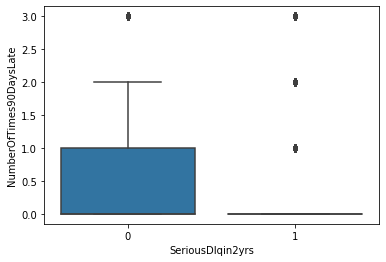

In [82]:
import seaborn as sns
sns.boxplot(x=train_data[y],y=t0)

### NumberRealEstateLoansOrLines

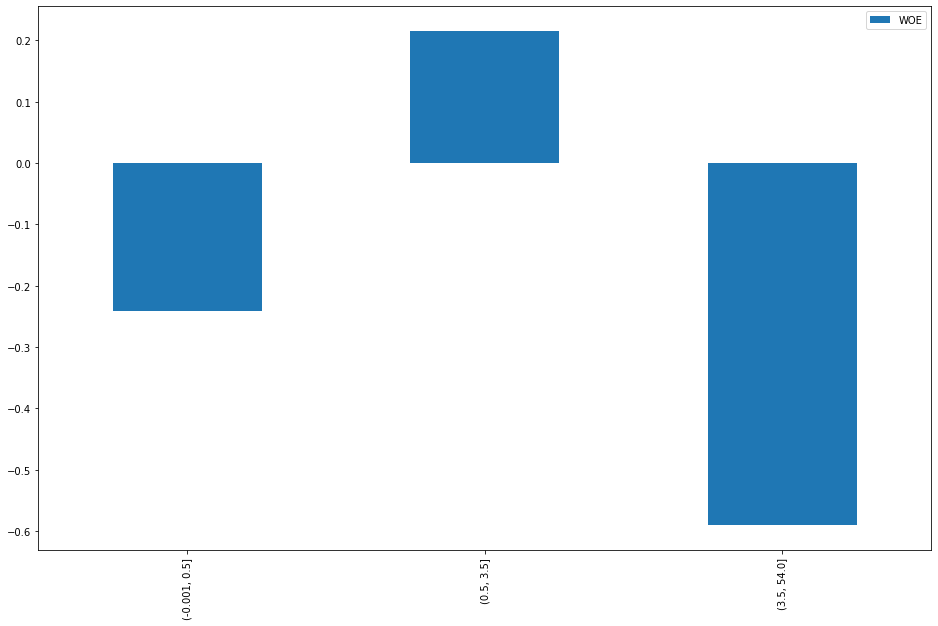

In [83]:
NRE = smbin(train_data,y,"NumberRealEstateLoansOrLines")

In [84]:
NRE.IVtable

Bins  CntRec  CntGood  CntBad    PctRec   PctGood    PctBad  \
0  (-0.001, 0.5]   55579    50924    4655  0.372037  0.365356  0.465081   
1     (0.5, 3.5]   90160    85225    4935  0.603517  0.611449  0.493056   
2    (3.5, 54.0]    3652     3233     419  0.024446  0.023195  0.041862   
3          Total  149391   139382   10009  1.000000  1.000000  1.000000   

      WOE      IV  
0 -0.2413  0.0241  
1  0.2152  0.0255  
2 -0.5904  0.0110  
3     NaN  0.0606

In [85]:
iv_all = iv_all.append(pd.Series({"NumberRealEstateLoansOrLines":NRE.IV}))

### NumberOfTime60_89DaysPastDueNotWorse

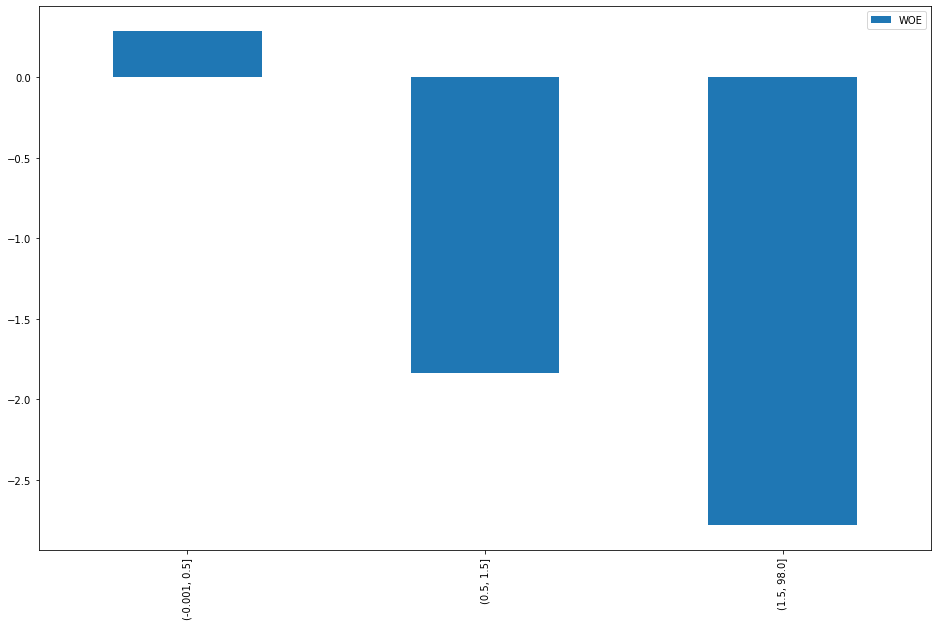

In [86]:
NO6089 = smbin(train_data,y,"NumberOfTime60_89DaysPastDueNotWorse")

In [87]:
NO6089.IVtable

Bins  CntRec  CntGood  CntBad    PctRec   PctGood    PctBad  \
0  (-0.001, 0.5]  141831   134581    7250  0.949395  0.965555  0.724348   
1     (0.5, 1.5]    5731     3954    1777  0.038362  0.028368  0.177540   
2    (1.5, 98.0]    1829      847     982  0.012243  0.006077  0.098112   
3          Total  149391   139382   10009  1.000000  1.000000  1.000000   

      WOE      IV  
0  0.2874  0.0693  
1 -1.8339  0.2736  
2 -2.7816  0.2560  
3     NaN  0.5989

In [88]:
iv_all = iv_all.append(pd.Series({"NumberOfTime60_89DaysPastDueNotWorse":NO6089.IV}))

### NumberOfDependents

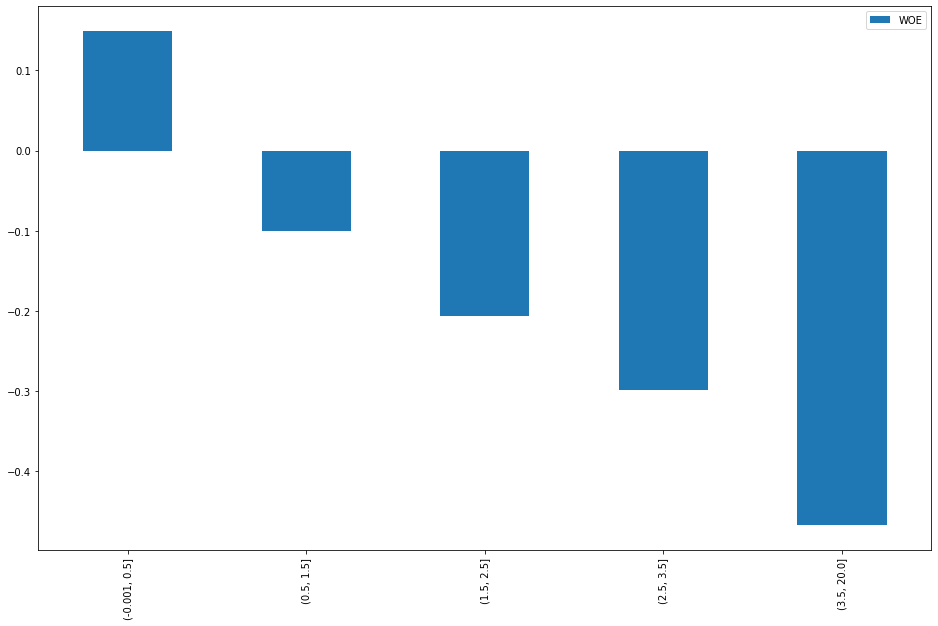

In [89]:
NOD = smbin(train_data,y,"NumberOfDependents")

In [90]:
NOD.IVtable

Bins  CntRec  CntGood  CntBad    PctRec   PctGood    PctBad  \
0  (-0.001, 0.5]   90220    84963    5257  0.603919  0.609569  0.525227   
1     (0.5, 1.5]   26314    24379    1935  0.176142  0.174908  0.193326   
2     (1.5, 2.5]   19521    17937    1584  0.130671  0.128690  0.158258   
3     (2.5, 3.5]    9483     8646     837  0.063478  0.062031  0.083625   
4    (3.5, 20.0]    3853     3457     396  0.025791  0.024802  0.039564   
5          Total  149391   139382   10009  1.000000  1.000000  1.000000   

      WOE      IV  
0  0.1489  0.0126  
1 -0.1001  0.0018  
2 -0.2068  0.0061  
3 -0.2987  0.0065  
4 -0.4670  0.0069  
5     NaN  0.0339

In [91]:
iv_all = iv_all.append(pd.Series({"NumberOfDependents":NOD.IV}))

## 查看所有变量IV值

- IV值用于筛选变量,删除小于0.02的变量

In [92]:
iv_all.sort_values(ascending=False)

RevolvingUtilizationOfUnsecuredLines    1.1487
NumberOfTimes90DaysLate                 0.8738
NumberOfTime30_59DaysPastDueNotWorse    0.7576
NumberOfTime60_89DaysPastDueNotWorse    0.5989
age                                     0.2523
NumberOfOpenCreditLinesAndLoans         0.1108
DebtRatio                               0.0889
NumberRealEstateLoansOrLines            0.0606
MonthlyIncome                           0.0480
NumberOfDependents                      0.0339
dtype: float64

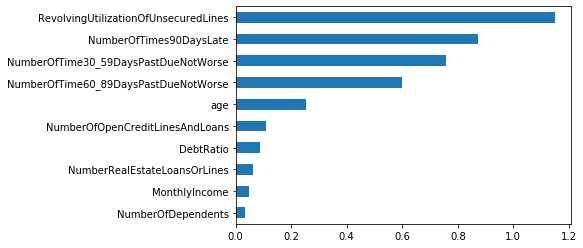

In [93]:
iv_all.sort_values().plot(kind="barh")

- 可见所有的IV值均大于0.02,故这里使用所有变量

## 生成WOE数据

- 之前smbin和smbin_cu得到的对象根据IV值筛选后,放在一个列表中

In [101]:
x_list = [RUO,age,NO3059,DebtRatio,MonthlyIncome,NOO,NO90,NRE,NO6089,NOD]

- 使用smgen函数根据得到的列表生成新数据

In [102]:
data_woe = smgen(train_data,x_list)

In [103]:
data_woe.head()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
1                 0                              0.766127   45   
2                 1                              0.957151   40   
3                 1                              0.658180   38   
4                 1                              0.233810   30   
5                 1                              0.907239   49   

   NumberOfTime30_59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
1                                     2   0.802982         9120.0   
2                                     0   0.121876         2600.0   
3                                     1   0.085113         3042.0   
4                                     0   0.036050         3300.0   
5                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
1                               13                        0   
2                                4                        0   
3                                2                        1   
4                                5                        0   
5                                7                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60_89DaysPastDueNotWorse  ...  \
1                             6                                     0  ...   
2                             0                                     0  ...   
3                             0                                     0  ...   
4                             0                                     0  ...   
5                             1                                     0  ...   

   RevolvingUtilizationOfUnsecuredLines_woe  age_woe  \
1                                   -0.8258  -0.1385   
2                                   -1.2175  -0.3249   
3                                   -0.3778  -0.3249   
4                                    0.7032  -0.5507   
5                                   -1.2175  -0.1385   

   NumberOfTime30_59DaysPastDueNotWorse_woe  DebtRatio_woe  MonthlyIncome_woe  \
1                                   -1.6142        -0.5947             0.3372   
2                                    0.5408         0.1117            -0.1429   
3                                   -0.9011         0.1117            -0.1429   
4                                    0.5408         0.1117            -0.1429   
5                                   -0.9011         0.1117             0.3372   

   NumberOfOpenCreditLinesAndLoans_woe  NumberOfTimes90DaysLate_woe  \
1                               0.1557                       0.3890   
2                               0.1557                       0.3890   
3                              -0.2318                      -1.9577   
4                               0.1557                       0.3890   
5                               0.1557                       0.3890   

   NumberRealEstateLoansOrLines_woe  NumberOfTime60_89DaysPastDueNotWorse_woe  \
1                           -0.5904                                    0.2874   
2                           -0.2413                                    0.2874   
3                           -0.2413                                    0.2874   
4                           -0.2413                                    0.2874   
5                            0.2152                                    0.2874   

   NumberOfDependents_woe  
1                 -0.2068  
2                 -0.1001  
3                  0.1489  
4                  0.1489  
5                  0.1489  

[5 rows x 21 columns]

- 抽取WOE列作为预测数据X
- 加常数项列
- 抽取响应列作为Y

In [104]:
len(x_list)

10

In [105]:
y

'SeriousDlqin2yrs'

In [97]:
X = data_woe.iloc[:,-len(x_list):]
X = sm.add_constant(X)   # 添加常数项   bias  w_0  截距
Y = data_woe[y]

- 分训练集和测试集

In [106]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=1221)

## 建模

- 建立逻辑回归模型,拟合数据,查看回归结果

In [107]:
glmodel = sm.Logit(Y_train,X_train,family=sm.families.Binomial()).fit()

Optimization terminated successfully.
         Current function value: 0.183496
         Iterations 8


In [108]:
glmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       SeriousDlqin2yrs   No. Observations:               104573
Model:                          Logit   Df Residuals:                   104562
Method:                           MLE   Df Model:                           10
Date:                Sun, 31 May 2020   Pseudo R-squ.:                  0.2566
Time:                        14:38:11   Log-Likelihood:                -19189.
converged:                       True   LL-Null:                       -25812.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                        2.5904      0.015    172.080      0.000       2.561       2.620
RevolvingUtilizationOfUnsecuredLines_woe     0.5972      0.014     41.501      0.000       0.569       0.625
age_woe                                      0.4368      0.032     13.733      0.000       0.374       0.499
NumberOfTime30_59DaysPastDueNotWorse_woe     0.5064      0.016     32.348      0.000       0.476       0.537
DebtRatio_woe                                0.7358      0.049     14.953      0.000       0.639       0.832
MonthlyIncome_woe                            0.1125      0.068      1.643      0.100      -0.022       0.247
NumberOfOpenCreditLinesAndLoans_woe          0.0018      0.042      0.044      0.965      -0.080       0.083
NumberOfTimes90DaysLate_woe                  0.5318      0.014     38.337      0.000       0.505       0.559
NumberRealEstateLoansOrLines_woe             0.5582      0.062      9.013      0.000       0.437       0.680
NumberOfTime60_89DaysPastDueNotWorse_woe     0.3755      0.017     22.153      0.000       0.342       0.409
NumberOfDependents_woe                       0.2586      0.078      3.313      0.001       0.106       0.412
============================================================================================================
"""

p的原假设是beta_i=0，其中0.887对应的beta就没用，从之前iv值看它是有用的，但在这里就没用了。前面iv值看的是两两相关性，但是两两相关不一定是真实的相关，有可能是间接相关而不是直接相关。（比如说冰淇淋销量和鲨鱼共计人的次数）两两相关能去掉没用的，但不一定留下的全是有用的。

### 查看共线性

- 如果有共线性，标准误会非常大
- 计算每个预测变量的vif值,查看是否存在共线性 
大于10存在严重的多重共线性   小于5不存在多重共线性

In [109]:
vif = [variance_inflation_factor(X_train.iloc[:,1:].values,i
                                 ) for i in range(X_train.shape[1]-1)]
print(pd.Series(dict(zip(X_train.columns[1:],vif))))

RevolvingUtilizationOfUnsecuredLines_woe    1.522287
age_woe                                     1.203879
NumberOfTime30_59DaysPastDueNotWorse_woe    1.355784
DebtRatio_woe                               1.149363
MonthlyIncome_woe                           1.112189
NumberOfOpenCreditLinesAndLoans_woe         1.186255
NumberOfTimes90DaysLate_woe                 1.421797
NumberRealEstateLoansOrLines_woe            1.191991
NumberOfTime60_89DaysPastDueNotWorse_woe    1.339409
NumberOfDependents_woe                      1.150708
dtype: float64


- 可见不存在共线性

## 生成评分卡

- 根据逻辑回归模型和之前筛选得到的列表,给定参数,生成评分卡
- 调整参数,使得评分卡分数范围满足需求

In [113]:
scorecard = smscale(glmodel,x_list,pdo=50,score=1150,odds=10)
scorecard.minmaxscore

[162, 793]

- 查看最终的评分卡

In [114]:
scorecard.ScoreCard

Characteristic            Attribute  Points
0  RevolvingUtilizationOfUnsecuredLines      (-0.001, 0.132]     119
1  RevolvingUtilizationOfUnsecuredLines       (0.132, 0.301]      91
2  RevolvingUtilizationOfUnsecuredLines       (0.301, 0.495]      68
3  RevolvingUtilizationOfUnsecuredLines       (0.495, 0.698]      45
4  RevolvingUtilizationOfUnsecuredLines       (0.698, 0.863]      25
5  RevolvingUtilizationOfUnsecuredLines       (0.863, 1.003]       9
6  RevolvingUtilizationOfUnsecuredLines     (1.003, 50708.0]     -30
0                                   age       (-0.001, 36.5]      44
1                                   age         (36.5, 43.5]      51
2                                   age         (43.5, 55.5]      57
3                                   age         (55.5, 62.5]      71
4                                   age        (62.5, 109.0]      91
0  NumberOfTime30_59DaysPastDueNotWorse        (-0.001, 0.5]      81
1  NumberOfTime30_59DaysPastDueNotWorse           (0.5, 1.5]      28
2  NumberOfTime30_59DaysPastDueNotWorse           (1.5, 2.5]       2
3  NumberOfTime30_59DaysPastDueNotWorse           (2.5, 3.5]     -12
4  NumberOfTime30_59DaysPastDueNotWorse          (3.5, 98.0]     -30
0                             DebtRatio    (-0.001, 1.3e-05]      43
1                             DebtRatio    (1.3e-05, 0.0163]      98
2                             DebtRatio      (0.0163, 0.423]      67
3                             DebtRatio       (0.423, 0.654]      50
4                             DebtRatio       (0.654, 3.973]      29
5                             DebtRatio    (3.973, 329664.0]      72
0                         MonthlyIncome     (-0.001, 6643.5]      60
1                         MonthlyIncome  (6643.5, 3008750.0]      64
0       NumberOfOpenCreditLinesAndLoans        (-0.001, 0.5]      61
1       NumberOfOpenCreditLinesAndLoans           (0.5, 1.5]      61
2       NumberOfOpenCreditLinesAndLoans           (1.5, 3.5]      61
3       NumberOfOpenCreditLinesAndLoans          (3.5, 13.5]      61
4       NumberOfOpenCreditLinesAndLoans         (13.5, 58.0]      61
0               NumberOfTimes90DaysLate        (-0.001, 0.5]      76
1               NumberOfTimes90DaysLate           (0.5, 1.5]     -13
2               NumberOfTimes90DaysLate          (1.5, 98.0]     -48
0          NumberRealEstateLoansOrLines        (-0.001, 0.5]      51
1          NumberRealEstateLoansOrLines           (0.5, 3.5]      70
2          NumberRealEstateLoansOrLines          (3.5, 54.0]      37
0  NumberOfTime60_89DaysPastDueNotWorse        (-0.001, 0.5]      69
1  NumberOfTime60_89DaysPastDueNotWorse           (0.5, 1.5]      11
2  NumberOfTime60_89DaysPastDueNotWorse          (1.5, 98.0]     -13
0                    NumberOfDependents        (-0.001, 0.5]      64
1                    NumberOfDependents           (0.5, 1.5]      59
2                    NumberOfDependents           (1.5, 2.5]      57
3                    NumberOfDependents           (2.5, 3.5]      55
4                    NumberOfDependents          (3.5, 20.0]      52

- 评分卡写出到csv文件

In [115]:
scorecard.ScoreCard.to_csv("ScoreCard.csv",index=False)

## 模型评估-评分模型的区分能力

- 根据之前的分卡对象得到测试集分数

In [116]:
testscore = smscoregen(scorecard,X_test)

In [117]:
testscore.head()

const  RevolvingUtilizationOfUnsecuredLines_woe  age_woe  \
0    1.0                                    1.3365  -0.1385   
1    1.0                                    1.3365  -0.3249   
2    1.0                                    1.3365  -0.1385   
3    1.0                                   -0.8258  -0.3249   
4    1.0                                    1.3365   0.9583   

   NumberOfTime30_59DaysPastDueNotWorse_woe  DebtRatio_woe  MonthlyIncome_woe  \
0                                   -0.9011         0.1117             0.3372   
1                                   -0.9011         0.1117             0.3372   
2                                    0.5408         0.6951             0.3372   
3                                    0.5408        -0.5947             0.3372   
4                                    0.5408         0.1117            -0.1429   

   NumberOfOpenCreditLinesAndLoans_woe  NumberOfTimes90DaysLate_woe  \
0                               0.1557                       0.3890   
1                               0.1557                      -1.9577   
2                               0.1557                       0.3890   
3                               0.1557                       0.3890   
4                              -0.2318                       0.3890   

   NumberRealEstateLoansOrLines_woe  NumberOfTime60_89DaysPastDueNotWorse_woe  \
0                            0.2152                                    0.2874   
1                            0.2152                                   -1.8339   
2                           -0.2413                                    0.2874   
3                            0.2152                                    0.2874   
4                            0.2152                                    0.2874   

   ...  age_Score  NumberOfTime30_59DaysPastDueNotWorse_Score  \
0  ...         57                                          28   
1  ...         51                                          28   
2  ...         57                                          81   
3  ...         51                                          81   
4  ...         91                                          81   

   DebtRatio_Score  MonthlyIncome_Score  \
0               67                   64   
1               67                   64   
2               98                   64   
3               29                   64   
4               67                   60   

   NumberOfOpenCreditLinesAndLoans_Score  NumberOfTimes90DaysLate_Score  \
0                                     61                             76   
1                                     61                            -13   
2                                     61                             76   
3                                     61                             76   
4                                     61                             76   

   NumberRealEstateLoansOrLines_Score  \
0                                  70   
1                                  70   
2                                  51   
3                                  70   
4                                  70   

   NumberOfTime60_89DaysPastDueNotWorse_Score  NumberOfDependents_Score  Score  
0                                          69                        55    666  
1                                          11                        59    517  
2                                          69                        55    731  
3                                          69                        57    583  
4                                          69                        64    758  

[5 rows x 22 columns]

- 通过测试集中真实的y,和预测的分数,绘制ks曲线
- 得到对应的最优阈值以及相关度量

The optimal cutoff(for ks) is 690.0
The maximum value of ks is: 0.5631
Score      690.000000
TP       33221.000000
FP         683.000000
FN        8635.000000
TN        2279.000000
rpp          0.756482
tpr          0.793697
fpr          0.230587
ppv          0.979855
acc          0.792092
f            0.877006
ks           0.563110
lift         1.049196
Name: 33903, dtype: float64


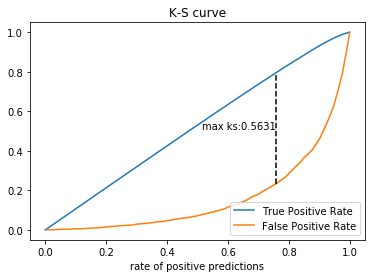

In [122]:
evaluate1 = evaluate01(Y_test,testscore["Score"],index="ks",plot="ks")

- 绘制ROC曲线

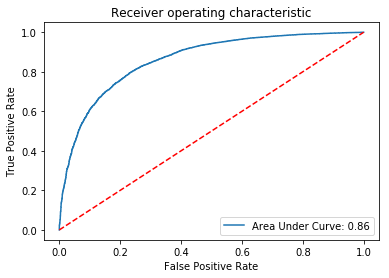

In [123]:
evaluate2 = evaluate01(Y_test,testscore["Score"],plot="roc",report=False)

## 新数据预测

- 读取待预测的新数据

In [115]:
os.chdir("D:/data/python")
test_data = pd.read_csv("cs-test.csv",index_col=0)

- 对数据进行与训练数据相同的清洗,即使用之前定义的清洗函数

In [116]:
test0 = datacleaning(test_data)

- 由之前得到的分箱对象生成包含woe列的数据

In [117]:
test_woe = smgennew(test0,x_list)
test_woe.head()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
1               NaN                              0.885519   43   
2               NaN                              0.463295   57   
3               NaN                              0.043275   59   
4               NaN                              0.280308   38   
5               NaN                              1.000000   27   

   NumberOfTime30_59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
1                                     0   0.177513         5700.0   
2                                     0   0.527237         9141.0   
3                                     0   0.687648         5083.0   
4                                     1   0.925961         3200.0   
5                                     0   0.019917         3865.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
1                                4                        0   
2                               15                        0   
3                               12                        0   
4                                7                        0   
5                                4                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60_89DaysPastDueNotWorse  ...  \
1                             0                                     0  ...   
2                             4                                     0  ...   
3                             1                                     0  ...   
4                             2                                     0  ...   
5                             0                                     0  ...   

   RevolvingUtilizationOfUnsecuredLines_woe  age_woe  \
1                                   -1.2175  -0.3249   
2                                    0.1515   0.3025   
3                                    1.3365   0.3025   
4                                    0.7032  -0.3249   
5                                   -1.2175  -0.5507   

   NumberOfTime30_59DaysPastDueNotWorse_woe  DebtRatio_woe  MonthlyIncome_woe  \
1                                    0.5408         0.1117             0.0025   
2                                    0.5408        -0.2128             0.3397   
3                                    0.5408        -0.5947            -0.1884   
4                                   -0.9011        -0.5947            -0.4417   
5                                    0.5408         0.1117            -0.1884   

   NumberOfOpenCreditLinesAndLoans_woe  NumberOfTimes90DaysLate_woe  \
1                               0.1557                        0.389   
2                              -0.0441                        0.389   
3                               0.1557                        0.389   
4                               0.1557                        0.389   
5                               0.1557                        0.389   

   NumberRealEstateLoansOrLines_woe  NumberOfTime60_89DaysPastDueNotWorse_woe  \
1                           -0.2413                                    0.2874   
2                           -0.5904                                    0.2874   
3                            0.2152                                    0.2874   
4                            0.2152                                    0.2874   
5                           -0.2413                                    0.2874   

   NumberOfDependents_woe  
1                  0.1489  
2                 -0.2068  
3                 -0.2068  
4                  0.1489  
5                 -0.1001  

[5 rows x 21 columns]

- 抽取WOE数据生成预测用数据
- 要加常数项列

In [118]:
T = test_woe.iloc[:,-len(x_list):]
T = sm.add_constant(T)

C:\Programs\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


- 预测每一行数据是好客户的概率

In [119]:
y_pred = glmodel.predict(T)

- 预测每行数据的分数,生成总分数和每个特征的分数

In [120]:
Tscore = smscoregen(scorecard,T)

- 根据分数和训练得到的阈值判断客户的好坏,好客户是1,坏客户是0

In [124]:
test0[y] = (Tscore.Score > evaluate1.cutoff)*1
test0.head()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
1               1.0                              0.885519   43   
2               1.0                              0.463295   57   
3               0.0                              0.043275   59   
4               0.0                              0.280308   38   
5               1.0                              1.000000   27   

   NumberOfTime30_59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
1                                     0   0.177513         5700.0   
2                                     0   0.527237         9141.0   
3                                     0   0.687648         5083.0   
4                                     1   0.925961         3200.0   
5                                     0   0.019917         3865.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
1                                4                        0   
2                               15                        0   
3                               12                        0   
4                                7                        0   
5                                4                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60_89DaysPastDueNotWorse  \
1                             0                                     0   
2                             4                                     0   
3                             1                                     0   
4                             2                                     0   
5                             0                                     0   

   NumberOfDependents  
1                 0.0  
2                 2.0  
3                 2.0  
4                 0.0  
5                 1.0